In [41]:
from Dirization import Dpreprocess_wav, VoiceEncoder
from pathlib import Path
from ASR.preprocessing import * 
from ASR.hparams import * 
import os
import json
import pandas as pd
import librosa.display
from Dirization.hparams import sampling_rate
from Dirization.audio import *
from Dirization.voice_encoder import *

In [70]:
#give the file path to your audio file and for the model
audio_file_path = './Data/DataForDirization/Samples3.wav'
wav_path = Path(audio_file_path)


modelD_file_path = './Models/DIRIZATIONMODEL.pt'
modelD_file_path= Path(modelD_file_path)

modelA_file_path = './Models/ASRMODEL.weights.h5'
modelA_file_path= Path(modelA_file_path)

modelA_Config_file_path = './Models/ASRMODELCONFIG.json'
modelA_Config_file_path= Path(modelA_Config_file_path)

## Load Dirization Model

In [71]:
wav = Dpreprocess_wav(wav_path)
encoder = VoiceEncoder("cpu", weights_fpath=modelD_file_path)
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=16)

Loaded the voice encoder model on cpu in 0.07 seconds.


In [72]:
print(f"Embedding shape: {cont_embeds.shape}")
print(f"Number of splits: {len(wav_splits)}")

Embedding shape: (274, 256)
Number of splits: 274


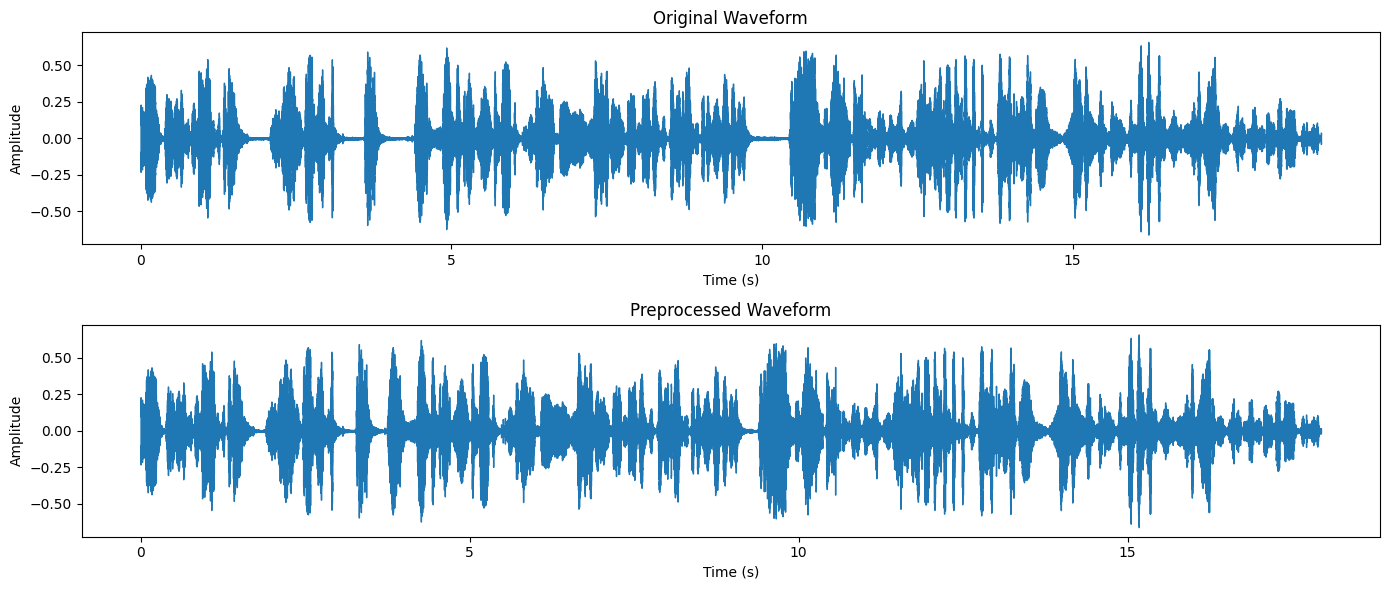

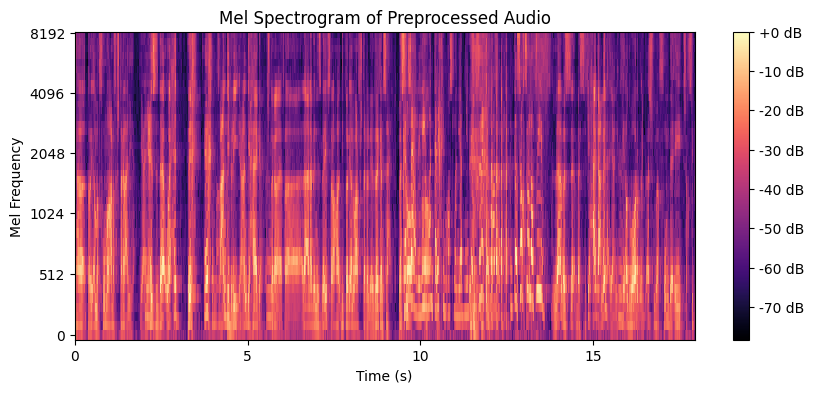

In [73]:
# Preprocess the audio
preprocessed_wav = Dpreprocess_wav(audio_file_path)

# Load original audio for comparison
original_wav, original_sr = librosa.load(audio_file_path, sr=None)

# Visualize Waveforms
plt.figure(figsize=(14, 6))

# Plot original waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(original_wav, sr=original_sr)
plt.title('Original Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot preprocessed waveform
plt.subplot(2, 1, 2)
librosa.display.waveshow(preprocessed_wav, sr=sampling_rate)
plt.title('Preprocessed Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Visualize Mel Spectrogram of Preprocessed Audio
mel_spectrogram = wav_to_mel_spectrogram(preprocessed_wav)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram.T, ref=np.max), sr=sampling_rate, 
                         hop_length=int(sampling_rate * mel_window_step / 1000), 
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Preprocessed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.show()


In [74]:
from sklearn.manifold import TSNE
import numpy as np

# Convert continuous embeddings to a numpy array
embeddings = np.array(cont_embeds)

# Use t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


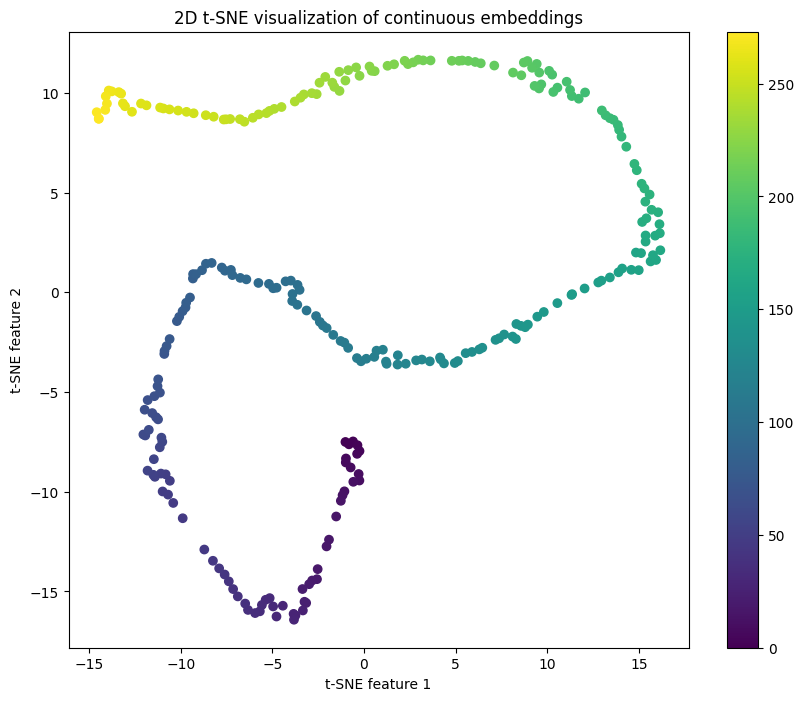

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(embeddings_2d)), cmap='viridis')
plt.colorbar()
plt.title("2D t-SNE visualization of continuous embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.show()

In [76]:
from spectralcluster import SpectralClusterer
from spectralcluster.utils import EigenGapType

clusterer = SpectralClusterer(
    min_clusters=2,
    max_clusters=10,
    eigengap_type=EigenGapType.Ratio
)
labels = clusterer.predict(cont_embeds)

In [77]:
import json
# import numpy as np

def create_labelling(labels, wav_splits):
    
    from Dirization import sampling_rate
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    labelling = []
    start_time = 0

    for i, time in enumerate(times):
        if i > 0 and labels[i] != labels[i - 1]:
            temp = {
                "start": float(start_time),
                "end": float(time),
                "speaker": int(labels[i - 1])
            }
            labelling.append(temp)
            start_time = time
        if i == len(times) - 1:
            temp = {
                "start": float(start_time),
                "end": float(time),
                "speaker": int(labels[i])
            }
            labelling.append(temp)

    return labelling

predicted_data = create_labelling(labels, wav_splits)

# Save the labelling to a JSON file
with open('./Output/Ourlabelling.json', 'w', encoding='utf-8') as f:
    json.dump(predicted_data, f, ensure_ascii=False, indent=4)

print("Labelling saved to labelling.json")

Labelling saved to labelling.json


In [78]:
predicted_data

[{'start': 0.0, 'end': 9.02, 'speaker': 1},
 {'start': 9.02, 'end': 13.64, 'speaker': 0},
 {'start': 13.64, 'end': 17.18, 'speaker': 1}]